The meaning behind Probability and Statstics:

https://byjus.com/maths/probability-and-statistics/

Probability is how likely an event is to occur. (Like flipping a coin, P(Heads) = 1/2)

3 different types of probability: (all good things come in three)

Theoretical Probability - based on reasoning.
Experimental Probability - based on observed data
Axiomatic Probability - builds on formal rules (Kolmogorov's axioms) 

Statistics is the study of how to collect, summarize, interpret, present and draw conclusions from data of any kind.

Data can be Quantitative (like numerica data, countable, or any value in a range) vs Qualitative (categorical or descriptive)

**(Example problems on there aswell, do later)**

Variance measures the spread of outcomes around the mean.

Explore more: https://www.studocu.com/ph/document/sti-west-negros-university/electrical-engineering/probability-and-statistics-definition-terms-formulas-and-examples/41414861?utm_source=chatgpt.com


In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [23]:
rest_lines = np.array([5000.0, 6000.0, 6500.0])   # H‑beta, [O III], H‑alpha-ish placeholders
amps       = np.array([1.0,   0.8,   0.6])        # relative line strengths/

In [24]:
wl = np.linspace(4800, 9000, 7000)

# Guassian:
# w: an array of values. Represents the wavelength.
# w0: represents the center of the peak where Gaussian is tallest.
# amp: the amplitude of the peak
# sigma: a small sigma makes the peak narrow and steep. 
# big sigma makes it wide and smooth
def gaussian(w, w0, amp, sigma=3.0):
    """Simple Gaussian line profile"""
    return amp * np.exp(-(w - w0)**2 / (2.0 * sigma**2))

#Zeros_like returns an array of zeros 
# with the same shape and size as a

# Build rest‑frame template spectrum
template_flux = np.zeros_like(wl)
for w0, amp in zip(rest_lines, amps):
    template_flux += gaussian(wl, w0, amp)

The equation looks like this:

$$ f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} $$


$x$ represents the Variable

$\mu$ represents the Mean

$\sigma$ represents standard deviation

$e$ represents the base of the natural log.

properties of Gaussian Distribution:
    
-Symmetric around it's mean

-unimodal (one MODE) (means only one peak)

-Asymptotic

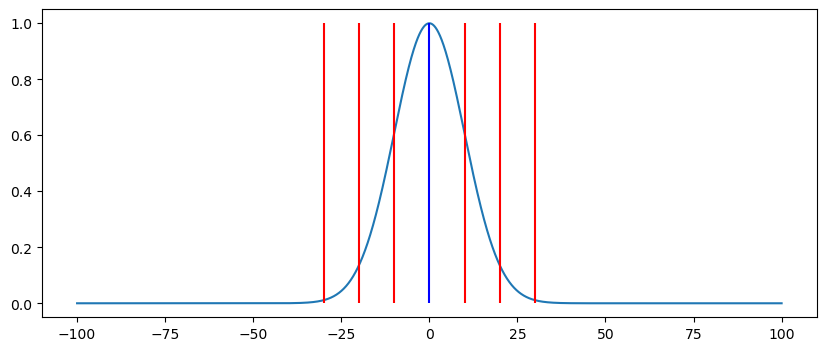

In [25]:
# The X and Y values for the plot below.

gaussianX = np.linspace(-100, 100, 3000)

sd = 10
mean = np.mean(gaussianX)

# Calculating gaussian Y values.
gaussianY = gaussian(mean, gaussianX, 1, sigma= sd)

plt.figure(figsize=(10, 4))
plt.plot(gaussianX, gaussianY)

# Below is the different standard deviation(s) from 1 to 3. The blue line is the mean.
plt.vlines(x=mean, colors=['b'], ymin=0, ymax=1)
for n in range(1, 4):
    plt.vlines(x=mean + n * sd, colors=['r'], ymin=0, ymax=1)
    plt.vlines(x=mean - n * sd, colors=['r'], ymin=0, ymax=1)


plt.show()


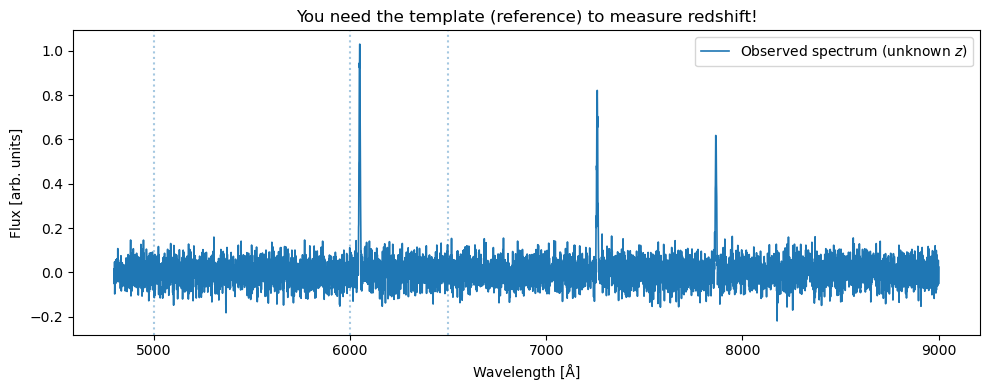

In [26]:
# ------------------------------------
# Apply a redshift to generate “data”
# ------------------------------------
z_true = np.random.random()                    # the unknown redshift we’ll try to recover
obs_lines = (1.0 + z_true) * rest_lines

observed_flux = np.zeros_like(wl)
for w0, amp in zip(obs_lines, amps):
    observed_flux += gaussian(wl, w0, amp)

# Add a touch of noise so it looks more realistic
rng = np.random.default_rng(42)
observed_flux += 0.05 * rng.normal(size=wl.size)

# ------------------------------------
# Plot: template vs. observed spectrum
# ------------------------------------


plt.figure(figsize=(10, 4))
plt.plot(wl, observed_flux, label=f"Observed spectrum (unknown $z$)", linewidth=1.2)

    #plt.scatter(peaks, wl[peaks])
#plt.plot(wl, template_flux, '--', label="Template (rest‑frame)", linewidth=1.2)

# Mark the *rest* wavelengths (dotted) and observed wavelengths (dash‑dot)
for w_rest, w_obs in zip(rest_lines, obs_lines):
    plt.axvline(w_rest, linestyle=':', alpha=0.4)
    #plt.axvline(w_obs,  linestyle='-.', alpha=0.4)


plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [arb. units]")
plt.title("You need the template (reference) to measure redshift!")
plt.legend()
plt.tight_layout()
plt.show()

The sources I used to learn Cross Correlation:
https://liquidinstruments.com/blog/cross-correlation-and-spectrum-analysis/

https://www.youtube.com/watch?v=cuD-LXic2cE

Cross correlation is the measurement of how well two independent signals resemble each other, a concept known as cross-similarity.
Mathematically, cross-correlation is defined as the intergral of the product of two signals. One signal is given a time delay, T, and the cross-correlation is represented as a function of this time delay.

EX.
When two signals do not have any time overlap, the function is zero. Depending on whether the signals are of similar or opposite amplitudes, the correlation function cano also take on positive and negative values. 

**Signal analysis: Compare a incoming signal to a known template can detect events. 



The equation for Correlation is described as:

$$ r[m] = \sum_{n=0}^{N_1 + N_2 - 2}x_1[n]\space x_2[n+m] $$

Basically, this equation shifts the x_2 array over by 1 (adds it to the last index and moves up the 2nd in line) and r[m] is the sum  of every number in the x_1 array times it's indice in the x_2 array. Where it is the highest value is where it is most correlated (?) (Matches up the best)

The equation for the scipy Correlation:

$$ z[k] = \sum_{l = 0}^{N-1} x_l y_{l-k}^* $$

This matches (each piece) of how well x matches a shifted version of y. also has lag (like the shifted by 1 above) the * means a complex conjugate. pretty cool. Where x and y line up, z[k] will be a high value.

In [27]:
# Setting up the two arrays to show where (or what) x values REALLY match up, to show where they are on the wavelength vs. correlation graph.

# np.argmin() finds the index of the lowest value in the array. wl-rest_lines[at 0, 1, 2]
# returns an array of subtracted values, either pos or neg. 
indc = [np.argmin(np.abs(wl - line)) for line in rest_lines]

# So, If we print out indcies, we will get the closest matching values to each line in rest_lines.
print(f"The closest numbers I found to {rest_lines} in the array wl are {wl[indc]}.")

The closest numbers I found to [5000. 6000. 6500.] in the array wl are [4999.82854694 6000.17145306 6500.04286327].


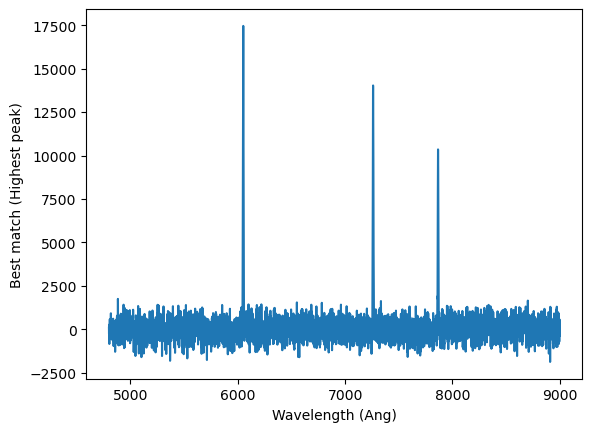

In [28]:
from scipy.signal import correlate

x_1 = rest_lines
x_2 = observed_flux

# correlate method is associate with the above equation.
correlation = correlate(x_2, x_1)[0:7000]


plt.ylabel("Best match (Highest peak)")
plt.xlabel("Wavelength (Ang)")
plt.plot(wl, correlation)

So, now we have found the places where it has the highest peak-- Where it matches (correlates) to our vertical lines the most! time to calculate redshift..

[6051.17873982 7260.35147878 7865.23789113]


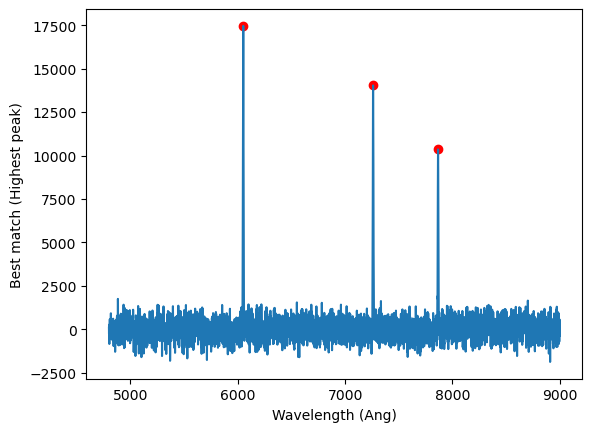

In [29]:
from scipy.signal import find_peaks
# find_peaks scans my data and points to the top of the hills. Like my implementation called 'find moutains' in Alg2. Except, It can set a threshold.

peaks, _ = find_peaks(correlation, height=2500, distance=100) # Finds peaks above 2500. could've possibly done this with the 3*std+mean and then my find_moutains alg. but this is wayy quicker. 

observed_lines = wl[peaks]

print(observed_lines)
# The red dots represent the highest points on this graph.
plt.scatter(observed_lines, correlation[peaks], color='r')
plt.ylabel("Best match (Highest peak)")
plt.xlabel("Wavelength (Ang)")
plt.plot(wl, correlation)

[6051.17873982 7260.35147878 7865.23789113]
[5000. 6000. 6500.]
Matched 5000.0 to 6051.178739819974
Matched 6000.0 to 7260.351478782683
Matched 6500.0 to 7865.2378911273045
Final redshift = 0.21011030879869286. True redshift is 0.2099915258695113.


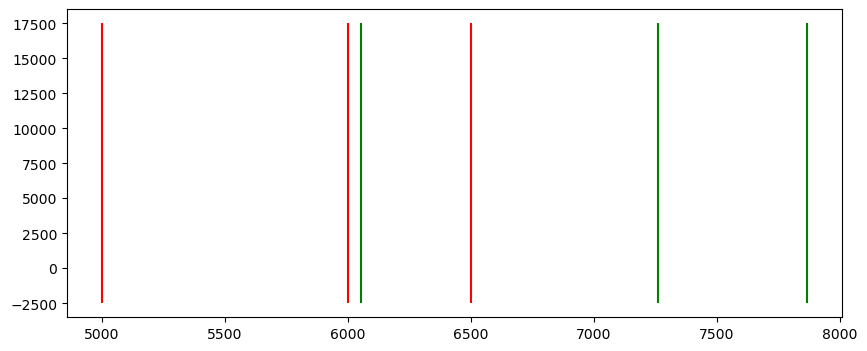

In [30]:
redshifts = []
matched = []
print(observed_lines)
print(rest_lines)
# All elements have a specific "fingerprint." If the number of emmision and observed lines aren't equal, then it is not possible.
if len(observed_lines) == len(rest_lines):

    for i in range(len(rest_lines)):
        z = (observed_lines[i] - rest_lines[i]) / rest_lines[i]

        # Is that redshift possible?
        if -0.001 < z < 1.0:
            redshifts.append(z)
            matched.append((rest_lines[i], observed_lines[i]))
            print(f"Matched {rest_lines[i]} to {observed_lines[i]}")
        else:
            print(f'Rejected. Redshift {z} is not real.')
else:
    print('Not enough peaks!')

final_z = np.average(redshifts)
print(f"Final redshift = {final_z}. True redshift is {z_true}.")



 # The red dots represent the highest points on this graph.   
plt.figure(figsize=(10,4))
plt.vlines(observed_lines, ymax= 17500, ymin= -2500, colors=['g'])
plt.vlines(rest_lines, ymax= 17500, ymin= -2500, colors=['r'])